In [1]:
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras import layers, callbacks

from keras.utils import to_categorical

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

from scipy.stats import norm
from scipy import stats
import os

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import pickle
import dataframe_image as dfi

2023-05-10 12:40:54.329277: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-10 12:40:54.356206: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Save parameters

In [2]:
time_data_amount = 20
nr_classes = 3

using_weights = False

In [3]:
name = 'one_channel_test' #name of model - should be descriptive
save_folder = 'Reference_model_test_' + str(time_data_amount) #hyperparameter description her
if using_weights == True:
    save_folder = save_folder + '_W'
    name = name + '_weighted'

### Gotta load in some data

In [4]:
datapath = '../../../All generated data/'
labelpath = '../../../All generated labels/'
data_list = os.listdir(datapath)
#print(data_list)

#all_data = [] #if we want to have data and labels in one list
all_datapoints = []
all_labels = []

total_channels = 79
total_scans_pr_sample = 20
classes = 3


for csv_file in data_list:
    data_file = datapath + csv_file
    current_data_file = pd.read_csv(data_file,header=None)

    label_file = labelpath + csv_file
    label_file = label_file.replace('.csv', '_labels.csv')
    current_label_file = pd.read_csv(label_file,header=None)

    for data_iter in range(len(current_data_file.index)):
        #Pulling out the data from a row and putting it in the list
        current_data_point = np.array(current_data_file.iloc[data_iter])
        current_data_point = current_data_point.reshape(total_scans_pr_sample,total_channels)
        all_datapoints.append(current_data_point)
        
        #adding the label to the datamatrix as the last row
        label_row = np.array(current_label_file.iloc[data_iter])
        label_row = label_row.reshape(1,total_channels)
        all_labels.append(label_row)
        
        #all_data.append(np.vstack([current_data_point, label_row])) #if we want to have data and labels in one list


In [5]:
print(all_labels[1].shape)
print(len(all_labels))
print(len(all_datapoints))

(1, 79)
10981
10981


#### Pick out one channel for each sample
For now it takes the same channel for all samples

In [6]:
chosen_channels = list(range(1,78,3))

complete_data = []
complete_labels = []

for iter in range(len(all_datapoints)):
    for channel in chosen_channels:
        complete_data.append(all_datapoints[iter][0:time_data_amount,channel])
        complete_labels.append(all_labels[iter][:,channel])
    

#quick check to make sure it works
print(complete_data[1].shape)
print(len(complete_data))
print(complete_labels[1].shape)
print(len(complete_labels))

(20,)
285506
(1,)
285506


### Splits data in train and test

In [7]:
data_train, data_test, labels_train, labels_test = train_test_split(complete_data, complete_labels, train_size=0.8, random_state=112)

# One hot encoding
labels_test = to_categorical(labels_test)
labels_train = to_categorical(labels_train)

data_train = np.array(data_train)
data_test = np.array(data_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
print(labels_test.shape)

(57102, 3)


### Normalise data a bit

In [8]:
# Make a scaler from training data
scaler = preprocessing.StandardScaler().fit(data_train)

# scale everything using that scaler
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

### Stuff for class weights

In [9]:
def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [10]:
class_weights = generate_class_weights(labels_train, multi_class=False, one_hot_encoded=True)

## Building a model

In [11]:
signal_size = time_data_amount

y = layers.Input(shape=(signal_size,1), dtype='float32', name='Input')

x = layers.Conv1D(16, 3, padding='same', activation='relu', use_bias=True)(y)
#x = layers.Dropout(rate=0.1)(x)
x = layers.Conv1D(16, 3, padding='same', activation='relu')(x)
x = layers.MaxPool1D(pool_size=2,strides=2)(x)
x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)

x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPool1D(pool_size=3,strides=1)(x)



x = layers.Flatten()(x)
x = layers.Dropout(rate=0.4)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(rate=0.4)(x)
x = layers.Dense(16,activation='relu')(x)
p = layers.Dense(classes, activation='softmax', name='p')(x)

model = Model(inputs=[y], outputs=[p])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 20, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 20, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 20, 16)            784       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 16)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 10, 32)            1568      
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 32)            3104      
                                                             

2023-05-10 12:41:07.178528: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 12:41:07.186853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-10 12:41:07.187006: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [12]:
# ------------- model compilation --------------
ourAdam = Adam()
model.compile(optimizer=ourAdam, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Set the model training parameters
# Stop model training when the training loss is not dropped
callbacks_list = [callbacks.EarlyStopping(
                        monitor='val_loss', 
                        patience=50, 
                        verbose=0, 
                        mode='auto',
                        restore_best_weights=True,
                    )
                            ]

# ------------- Starting model Training --------------
BATCH_SIZE = 4096
EPOCH = 800

if using_weights == True:
    w_for_fit = class_weights
else:
    w_for_fit = None
    

hist = model.fit(data_train,labels_train, 
          batch_size = BATCH_SIZE, 
          epochs = EPOCH, 
          callbacks= callbacks_list,
          validation_split=0.25,
          class_weight=w_for_fit)

Epoch 1/800


2023-05-10 12:41:08.718145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-10 12:41:09.268764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


42/42 [==============================] - 3s 30ms/step - loss: 0.9064 - accuracy: 0.6364 - val_loss: 0.6963 - val_accuracy: 0.7231
Epoch 2/800
42/42 [==============================] - 0s 8ms/step - loss: 0.6604 - accuracy: 0.7435 - val_loss: 0.6065 - val_accuracy: 0.7576
Epoch 3/800
42/42 [==============================] - 0s 8ms/step - loss: 0.6155 - accuracy: 0.7571 - val_loss: 0.5895 - val_accuracy: 0.7630
Epoch 4/800
42/42 [==============================] - 0s 8ms/step - loss: 0.5952 - accuracy: 0.7646 - val_loss: 0.5658 - val_accuracy: 0.7774
Epoch 5/800
42/42 [==============================] - 0s 8ms/step - loss: 0.5727 - accuracy: 0.7790 - val_loss: 0.5419 - val_accuracy: 0.8005
Epoch 6/800
42/42 [==============================] - 0s 8ms/step - loss: 0.5503 - accuracy: 0.7976 - val_loss: 0.5253 - val_accuracy: 0.8119
Epoch 7/800
42/42 [==============================] - 0s 8ms/step - loss: 0.5358 - accuracy: 0.8077 - val_loss: 0.5085 - val_accuracy: 0.8181
Epoch 8/800
42/42 [=====

Epoch 59/800
42/42 [==============================] - 0s 7ms/step - loss: 0.4370 - accuracy: 0.8478 - val_loss: 0.4294 - val_accuracy: 0.8518
Epoch 60/800
42/42 [==============================] - 0s 8ms/step - loss: 0.4359 - accuracy: 0.8479 - val_loss: 0.4300 - val_accuracy: 0.8509
Epoch 61/800
42/42 [==============================] - 0s 8ms/step - loss: 0.4362 - accuracy: 0.8482 - val_loss: 0.4362 - val_accuracy: 0.8490
Epoch 62/800
42/42 [==============================] - 0s 7ms/step - loss: 0.4370 - accuracy: 0.8481 - val_loss: 0.4305 - val_accuracy: 0.8515
Epoch 63/800
42/42 [==============================] - 0s 8ms/step - loss: 0.4348 - accuracy: 0.8489 - val_loss: 0.4329 - val_accuracy: 0.8501
Epoch 64/800
42/42 [==============================] - 0s 8ms/step - loss: 0.4354 - accuracy: 0.8484 - val_loss: 0.4339 - val_accuracy: 0.8500
Epoch 65/800
42/42 [==============================] - 0s 8ms/step - loss: 0.4337 - accuracy: 0.8493 - val_loss: 0.4286 - val_accuracy: 0.8514
Epoch 

42/42 [==============================] - 0s 7ms/step - loss: 0.4015 - accuracy: 0.8616 - val_loss: 0.4034 - val_accuracy: 0.8617
Epoch 174/800
42/42 [==============================] - 0s 8ms/step - loss: 0.4021 - accuracy: 0.8614 - val_loss: 0.4040 - val_accuracy: 0.8608
Epoch 175/800
42/42 [==============================] - 0s 8ms/step - loss: 0.4013 - accuracy: 0.8618 - val_loss: 0.4055 - val_accuracy: 0.8608
Epoch 176/800
42/42 [==============================] - 0s 7ms/step - loss: 0.4015 - accuracy: 0.8619 - val_loss: 0.4038 - val_accuracy: 0.8616
Epoch 177/800
42/42 [==============================] - 0s 7ms/step - loss: 0.4019 - accuracy: 0.8618 - val_loss: 0.4033 - val_accuracy: 0.8616
Epoch 178/800
42/42 [==============================] - 0s 8ms/step - loss: 0.4016 - accuracy: 0.8613 - val_loss: 0.4082 - val_accuracy: 0.8592
Epoch 179/800
42/42 [==============================] - 0s 8ms/step - loss: 0.4024 - accuracy: 0.8613 - val_loss: 0.4021 - val_accuracy: 0.8621
Epoch 180/800

42/42 [==============================] - 0s 8ms/step - loss: 0.3888 - accuracy: 0.8662 - val_loss: 0.3967 - val_accuracy: 0.8643
Epoch 288/800
42/42 [==============================] - 0s 8ms/step - loss: 0.3914 - accuracy: 0.8651 - val_loss: 0.3959 - val_accuracy: 0.8646
Epoch 289/800
42/42 [==============================] - 0s 8ms/step - loss: 0.3898 - accuracy: 0.8656 - val_loss: 0.3952 - val_accuracy: 0.8639
Epoch 290/800
42/42 [==============================] - 0s 8ms/step - loss: 0.3894 - accuracy: 0.8656 - val_loss: 0.3942 - val_accuracy: 0.8646
Epoch 291/800
42/42 [==============================] - 0s 8ms/step - loss: 0.3883 - accuracy: 0.8661 - val_loss: 0.3974 - val_accuracy: 0.8634
Epoch 292/800
42/42 [==============================] - 0s 7ms/step - loss: 0.3899 - accuracy: 0.8658 - val_loss: 0.3980 - val_accuracy: 0.8628
Epoch 293/800
42/42 [==============================] - 0s 8ms/step - loss: 0.3897 - accuracy: 0.8655 - val_loss: 0.3965 - val_accuracy: 0.8644
Epoch 294/800

In [14]:
def createDir(path: str):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
        print('Created "' + path + '" directory')
    else:
        print('"'+ path + '" directory already existed')

createDir(save_folder)

Created "Reference_model_test_20" directory


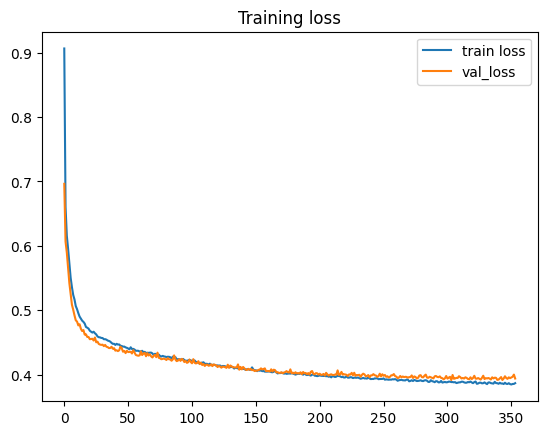

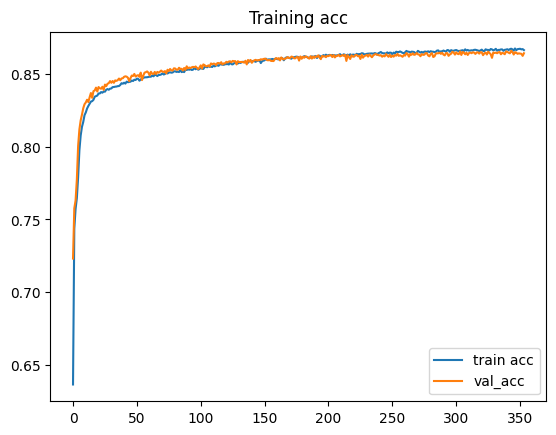

In [15]:
# Show loss curves
plt.figure()
plt.title('Training loss')
plt.plot(hist.epoch, hist.history['loss'], label='train loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig(save_folder + '/%s Training loss.pdf' %(name), format='pdf')
# plt.show()

plt.figure()
plt.title('Training acc')
plt.plot(hist.epoch, hist.history['accuracy'], label='train acc')
plt.plot(hist.epoch, hist.history['val_accuracy'], label='val_acc')
plt.legend()
plt.savefig(save_folder + '/%s Training acc.pdf' %(name), format='pdf')

In [ ]:
evalDict = model.evaluate(data_test,labels_test)

In [16]:
from keras.utils.layer_utils import count_params
test = count_params(model.trainable_weights)

cre = open(save_folder + '/' + 'Params_' + str(test), 'x')

1785/1785 [==============================] - 3s 2ms/step - loss: 0.3803 - accuracy: 0.8695


In [17]:
# Saving dict of history and evaluation result
with open(save_folder + '/' + 'histDict', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

with open(save_folder + '/' + 'evalDict' + str(evalDict[1]), 'wb') as file_pi:
    pickle.dump(evalDict, file_pi)

In [18]:
#uncomment to save model
model.save(save_folder + '/' + name + '_Model')

2023-05-10 13:11:10.264232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-10 13:11:10.271985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-05-10 13:11:10.467379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-10 13:11:

INFO:tensorflow:Assets written to: Reference_model_test_20/one_channel_test_Model/assets


INFO:tensorflow:Assets written to: Reference_model_test_20/one_channel_test_Model/assets


In [19]:
Y_test = np.argmax(labels_test, axis=1) # Convert one-hot to index
y_pred = np.argmax(model.predict(data_test),axis=1)
class_names = ['Empty channel', 'Wi-Fi', 'Bluetooth']
class_report = classification_report(Y_test, y_pred, target_names=class_names)
print(class_report)

with open(save_folder + '/' + 'classReportString', 'wb') as file_pi:
    pickle.dump(class_report, file_pi)

1785/1785 [==============================] - 2s 1ms/step
               precision    recall  f1-score   support

Empty channel       0.87      0.99      0.92     35386
        Wi-Fi       0.91      0.77      0.83     11353
    Bluetooth       0.83      0.59      0.69     10363

     accuracy                           0.87     57102
    macro avg       0.87      0.78      0.81     57102
 weighted avg       0.87      0.87      0.86     57102



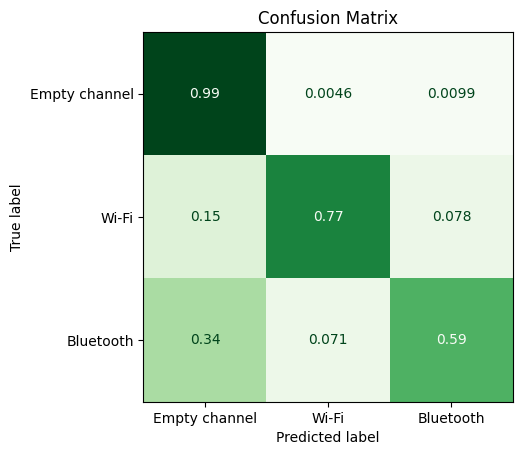

In [20]:
ConfusionMatrixDisplay.from_predictions(Y_test, y_pred, normalize='true',cmap='Greens',colorbar=False, display_labels=class_names)
plt.title('Confusion Matrix')
plt.savefig(save_folder +'/confusion_matrix_'+ name +'.pdf', format='pdf')

In [21]:
class_reportDict = classification_report(Y_test, y_pred, output_dict=True, target_names=class_names)
for key in class_reportDict:
    try:
        class_reportDict[key]['Samples'] = class_reportDict[key].pop('support')
    except Exception as e:
        print(e)
print(class_reportDict)


'float' object has no attribute 'pop'
{'Empty channel': {'precision': 0.8676536451853695, 'recall': 0.9854462216695868, 'f1-score': 0.9228061818566741, 'Samples': 35386}, 'Wi-Fi': {'precision': 0.9062922516900676, 'recall': 0.7675504271998591, 'f1-score': 0.8311713086608166, 'Samples': 11353}, 'Bluetooth': {'precision': 0.831163491845964, 'recall': 0.5852552349705684, 'f1-score': 0.6868629671574179, 'Samples': 10363}, 'accuracy': 0.8694966901334454, 'macro avg': {'precision': 0.868369796240467, 'recall': 0.7794172946133381, 'f1-score': 0.8136134858916361, 'Samples': 57102}, 'weighted avg': {'precision': 0.8687134441519833, 'recall': 0.8694966901334454, 'f1-score': 0.8617678600934966, 'Samples': 57102}}


In [22]:
class_reportDict.pop('accuracy')
print(class_reportDict)

{'Empty channel': {'precision': 0.8676536451853695, 'recall': 0.9854462216695868, 'f1-score': 0.9228061818566741, 'Samples': 35386}, 'Wi-Fi': {'precision': 0.9062922516900676, 'recall': 0.7675504271998591, 'f1-score': 0.8311713086608166, 'Samples': 11353}, 'Bluetooth': {'precision': 0.831163491845964, 'recall': 0.5852552349705684, 'f1-score': 0.6868629671574179, 'Samples': 10363}, 'macro avg': {'precision': 0.868369796240467, 'recall': 0.7794172946133381, 'f1-score': 0.8136134858916361, 'Samples': 57102}, 'weighted avg': {'precision': 0.8687134441519833, 'recall': 0.8694966901334454, 'f1-score': 0.8617678600934966, 'Samples': 57102}}


In [23]:
df = pd.DataFrame(class_reportDict).transpose().round(decimals=3)
dfi.export(df, save_folder + '/' +name + "_ClassReport.png", table_conversion="matplotlib")